<a href="https://colab.research.google.com/github/sandeeprockstar/Pose_Estimation/blob/master/Copy_of_Singledensity_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/data/deep_direct_stat

/content/drive/My Drive/data/deep_direct_stat


In [3]:
import tensorflow as tf
import keras
import numpy as np

from keras import backend as K
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Activation, Lambda
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.layers.merge import concatenate

from utils.angles import deg2bit, bit2deg, rad2bit
from utils.losses import mad_loss_tf, cosine_loss_tf, von_mises_loss_tf, von_mises_log_likelihood_tf
from utils.losses import von_mises_log_likelihood_np, von_mises_neg_log_likelihood_keras
from utils.losses import maad_from_deg
from scipy.stats import sem
import matplotlib.pyplot as plt



from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1627311768371344868
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11838425189234203461
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5920608356772426564
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14648777152
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4561035211115591043
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [0]:
def vgg_model(n_outputs=1, final_layer=False, l2_normalize_final=False,
              image_height=50, image_width=50, n_channels=3,
              conv_dropout_val=0.2, fc_dropout_val=0.5, fc_layer_size=512):

    model = Sequential(name='VGG')

    model.add(Conv2D(24, kernel_size=(3, 3),
                     activation=None,
                     input_shape=[image_height, image_width, n_channels]))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(24, (3, 3), activation=None))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Activation('relu'))

    model.add(Conv2D(48, (3, 3), activation=None))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(48, (3, 3), activation=None))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Activation('relu'))

    model.add(Conv2D(64, (3, 3), activation=None))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), activation=None))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(conv_dropout_val))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(fc_dropout_val))

    if final_layer:
        model.add(Dense(n_outputs, activation=None))
        if l2_normalize_final:
            model.add(Lambda(lambda x: K.l2_normalize(x, axis=1)))

    return model

In [0]:
class DegreeVGG:

    def __init__(self,
             image_height=50,
             image_width=50,
             n_channels=3,
             n_outputs=1,
             predict_kappa=False,
             fixed_kappa_value=1.0):

        self.image_height = image_height
        self.image_width = image_width
        self.n_channels = n_channels

        self.X = Input(shape=[image_height, image_width, self.n_channels])

        self.vgg_x = vgg_model(n_outputs=1,
                          final_layer=True,
                          image_height=self.image_height,
                          image_width=self.image_width,
                          n_channels=self.n_channels)(self.X)

        self.model = Model(self.X, self.vgg_x)

    def evaluate(self, x, ytrue_deg, data_part):

        ypreds_deg = np.squeeze(self.model.predict(x))

        loss = maad_from_deg(ypreds_deg, ytrue_deg)

        results = dict()

        results['maad_loss'] = float(np.mean(loss))
        results['maad_loss_sem'] = float(sem(loss, axis=None))
        print("MAAD error (%s) : %f ± %fSEM" % (data_part,
                                             results['maad_loss'],
                                             results['maad_loss_sem']))

        return results

In [0]:
class BiternionVGG:

    def __init__(self,
                 image_height=50,
                 image_width=50,
                 n_channels=3,
                 loss_type='cosine',
                 predict_kappa=False,
                 fixed_kappa_value=1.0,
                 **kwargs):

        self.image_height = image_height
        self.image_width = image_width
        self.n_channels = n_channels
        self.predict_kappa = predict_kappa
        self.fixed_kappa_value = fixed_kappa_value
        self.hyp_params = kwargs
        self.n_u = kwargs.get('n_hidden_units', 8)
        self.learning_rate = kwargs.get('learning_rate', 1.0e-3)
        self.beta1 = kwargs.get('beta1', 0.9)
        self.beta2 = kwargs.get('beta2', 0.999)
        self.epsilon = kwargs.get('epsilon', 1.0e-7)
        self.conv_dropout = kwargs.get('conv_dropout', 0.2)
        self.fc_dropout = kwargs.get('fc_dropout', 0.5)
        self.vgg_fc_layer_size = kwargs.get('vgg_fc_layer_size', 512)
        self.loss_type = loss_type
        self.loss = self._pick_loss()

        self.X = Input(shape=[image_height, image_width, self.n_channels])

        vgg_x = vgg_model(final_layer=False,
                          image_height=self.image_height,
                          image_width=self.image_width,
                          n_channels=self.n_channels,
                          conv_dropout_val=self.conv_dropout,
                          fc_dropout_val=self.fc_dropout,
                          fc_layer_size=self.vgg_fc_layer_size)(self.X)
        print('vgg_x model loaded')

        self.y_pred = Lambda(lambda x: K.l2_normalize(x, axis=1))(Dense(2)(vgg_x))
        print('y_pred is predicted')

        if self.predict_kappa:
            self.kappa_pred = Lambda(lambda x: K.abs(x))(Dense(1)(vgg_x))
            self.model = Model(self.X, concatenate([self.y_pred, self.kappa_pred]))
        else:
            self.model = Model(self.X, self.y_pred)
            print('when predict model is false')

        self.optimizer = keras.optimizers.Adam(lr=self.learning_rate,
                                               beta_1=self.beta1,
                                               beta_2=self.beta2,
                                               epsilon=self.epsilon)
        print('optimizer called')

        self.model.compile(optimizer=self.optimizer, loss=self.loss,metrics=['accuracy'])
        print('compiler called')

    def _pick_loss(self):

        if self.loss_type == 'cosine':
            print("using cosine loss..")
            loss = cosine_loss_tf
        elif self.loss_type == 'von_mises':
            print("using von-mises loss..")
            loss = von_mises_loss_tf
        elif self.loss_type == 'mad':
            print("using mad loss..")
            loss = mad_loss_tf
        elif self.loss_type == 'vm_likelihood':
            print("using likelihood loss..")
            if self.predict_kappa:
                loss = von_mises_neg_log_likelihood_keras
                print('von mises keras')
            else:

                def _von_mises_neg_log_likelihood_keras_fixed(y_true, y_pred):
                    mu_pred = y_pred[:, 0:2]
                    kappa_pred = tf.ones([tf.shape(y_pred[:, 2:])[0], 1])*self.fixed_kappa_value
                    print('von mises keras fixed')
                    return -K.mean(von_mises_log_likelihood_tf(y_true, mu_pred, kappa_pred))

                loss = _von_mises_neg_log_likelihood_keras_fixed
        else:
            raise ValueError("loss should be 'mad','cosine','von_mises' or 'vm_likelihood'")

        return loss

    def fit(self, train_data, val_data, n_epochs, batch_size, callbacks=None):

        xtr, ytr_bit,  = train_data
        xval, yval_bit = val_data

        history = self.model.fit(xtr, ytr_bit,
                       batch_size=batch_size,
                       epochs=n_epochs,
                       validation_data=(xval, yval_bit),
                       callbacks=callbacks)
        print(history.history.keys())
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')
        plt.grid(True)

        if not self.predict_kappa:
            self.finetune_kappa(xval, yval_bit)
            print('finetune_kappa_called')

        return

    def save_weights(self, path):

        self.model.save_weights(path)

    def load_weights(self, path):

        self.model.load_weights(path)

    def finetune_kappa(self, x, y_bit, max_kappa=1000.0, verbose=False):
        ytr_preds_bit = self.model.predict(x)[:, 0:2]
        kappa_vals = np.arange(0, max_kappa, 1.0)
        log_likelihoods = np.zeros(kappa_vals.shape)
        for i, kappa_val in enumerate(kappa_vals):
            kappa_preds = np.ones([x.shape[0], 1]) * kappa_val
            log_likelihoods[i] = np.mean(von_mises_log_likelihood_np(y_bit, ytr_preds_bit, kappa_preds))
            print('log_likelihoods is being calculated')
            if verbose:
                print("kappa: %f, log-likelihood: %f" % (kappa_val, log_likelihoods[i]))
        max_ix = np.argmax(log_likelihoods)
        self.fixed_kappa_value = kappa_vals[max_ix]
        if verbose:
            print("best kappa : %f" % self.fixed_kappa_value)
        return self.fixed_kappa_value

    def evaluate(self, x, ytrue_bit, data_part, return_per_image=False):

        # ytrue_bit = deg2bit(ytrue_deg)
        ytrue_deg = bit2deg(ytrue_bit)
        ypreds = self.model.predict(x)
        # print(ypreds,' = ypred')
        ypreds_bit = ypreds[:, 0:2]
        ypreds_deg = bit2deg(ypreds_bit)

        if self.predict_kappa:
            kappa_preds = ypreds[:, 2:]
        else:
            kappa_preds = np.ones([ytrue_deg.shape[0], 1]) * self.fixed_kappa_value

        # print('ypreds_deg=',ypreds_bit)
        # print('ytrue_deg=',ytrue_deg)
        loss = maad_from_deg(ypreds_deg, ytrue_deg)

        results = dict()

        results['maad_loss'] = float(np.mean(loss))
        results['maad_loss_sem'] = float(sem(loss))
        print("MAAD error (%s) : %f pm %fSEM" % (data_part,
                                                results['maad_loss'],
                                                results['maad_loss_sem']))

        results['mean_kappa'] = float(np.mean(kappa_preds))
        results['std_kappa'] = float(np.std(kappa_preds))

        log_likelihoods = von_mises_log_likelihood_np(ytrue_bit, ypreds_bit, kappa_preds)

        results['log_likelihood_mean'] = float(np.mean(log_likelihoods))
        results['log_likelihood_sem'] = float(sem(log_likelihoods, axis=None))
        print("log-likelihood (%s) : %f pm %fSEM" % (data_part,
                                                    results['log_likelihood_mean'],
                                                    results['log_likelihood_sem']))

        if return_per_image:
            results['point_preds'] = bit2deg(deg2bit(ypreds_deg))
            results['maad'] = loss
            results['log_likelihood'] = log_likelihoods

        return results

    def pdf(self, x, x_vals):

        n_images = x.shape[0]

        x_vals_tiled = np.ones(n_images)
        # print('x_vals_tiled = ',x_vals_tiled)
        # print(x_vals_tiled.shape)

        preds = self.model.predict(x)
        mu_preds_bit = preds[:, 0:2]

        if self.predict_kappa:
            kappa_preds = preds[:, 2:]
        else:
            kappa_preds = np.ones([x.shape[0], 1]) * self.fixed_kappa_value

        log_likelihoods = np.zeros([n_images, len(x_vals)])

        for xid, xval in enumerate(x_vals):

            x_bit = rad2bit(x_vals_tiled*xval)
            # print('x_bit = ',x_bit)
            # print(x_bit.shape)

            log_likelihoods[:, xid] = np.exp(np.squeeze(von_mises_log_likelihood_np(x_bit, mu_preds_bit, kappa_preds)))

        return log_likelihoods

    def plot_pdf(self, x_test, y_test, step=1.0e-2,fid = 8):
        """fid is image number
        """
        import numpy as np
        from utils import angles
        import matplotlib.pyplot as plt
        %matplotlib inline

        xval = np.arange(0,2*np.pi,step) # prediction for angles between 0 and 360 degrees
        x_pdf = self.pdf(x_test,xval) # calculation of probability distribution
        angle = self.model.predict(x_test) # predicting the value of angle
        print(angle[1,0:2])
        plt.axvline(np.deg2rad(y_test)[fid], c='orange', label='ground truth') # plot of ground truth value in radians
        plt.axvline(angles.bit2rad(np.expand_dims(angle[1,0:2],axis=0)), c='darkblue', label='prediction') # plot of predicted value in radians
        plt.plot(xval, x_pdf[fid], label='predicted density') #plot of probability function
        plt.legend()
        
        return

In [23]:
model = BiternionVGG(image_height=50, image_width=50, n_channels=3, loss_type='vm_likelihood', predict_kappa=True, learning_rate=1e-3)

using likelihood loss..
von mises keras
vgg_x model loaded
y_pred is predicted
optimizer called
log_bessel_approx_large
log_bessel_approx_0
compiler called


In [0]:
from datasets import pascal3d

cls = 'aeroplane' 
pascaldb_path = '/content/drive/My Drive/data/pascal3d+_imagenet_train_test.h5'
x_train, y_train, x_val, y_val, x_test, y_test = pascal3d.load_pascal_data(pascaldb_path, cls=cls)

In [9]:
from datasets import caviar

caviar_path = '/content/drive/My Drive/data/CAVIAR-o.pkl.gz'
(xtr_cav, ytr_cav, info_tr), (xval_cav, yval_cav, info_val), (xte, yte_cav, info_te) = caviar.load_caviar(caviar_path)
print(xtr_cav.shape)
print(xval_cav.shape)
print(xte.shape)

(10802, 50, 50, 3)
(5444, 50, 50, 3)
(5445, 50, 50, 3)


In [11]:
from datasets import towncentre
towncentre_path = '/content/drive/My Drive/data/TownCentre.pkl.gz'
(xtr, ytr, img_names_tr), (xval, yval, img_names_val), (xte, yte, img_names_te) = towncentre.load_towncentre(towncentre_path)

# print(yte)
print(xte.shape)

Number of train samples: 6916
Number of validation samples: 874
Number of test samples: 904
(904, 50, 50, 3)


In [0]:
ytr_bit = deg2bit(ytr)
yval_bit = deg2bit(yval)
yte_bit = deg2bit(yte)
train_data = xtr,ytr_bit
val_data = xval, yval_bit

Train on 6916 samples, validate on 874 samples
Epoch 1/100
6916/6916 [==============================] - 3s 383us/step - loss: -0.0900 - accuracy: 0.0035 - val_loss: 1.4293 - val_accuracy: 0.0023
Epoch 2/100
6916/6916 [==============================] - 3s 377us/step - loss: -0.1226 - accuracy: 0.0017 - val_loss: 1.4005 - val_accuracy: 0.0023
Epoch 3/100
6916/6916 [==============================] - 3s 377us/step - loss: -0.1721 - accuracy: 0.0017 - val_loss: 1.5081 - val_accuracy: 0.0023
Epoch 4/100
6916/6916 [==============================] - 3s 375us/step - loss: -0.1904 - accuracy: 0.0019 - val_loss: 1.4554 - val_accuracy: 0.0023
Epoch 5/100
6916/6916 [==============================] - 3s 371us/step - loss: -0.2019 - accuracy: 0.0013 - val_loss: 1.5707 - val_accuracy: 0.0034
Epoch 6/100
6916/6916 [==============================] - 3s 378us/step - loss: -0.2239 - accuracy: 0.0019 - val_loss: 1.6807 - val_accuracy: 0.0011
Epoch 7/100
6916/6916 [==============================] - 3s 376us

{'log_likelihood_mean': -5.873676149442096,
 'log_likelihood_sem': 0.5821940412851342,
 'maad_loss': 23.23402053697974,
 'maad_loss_sem': 1.0986177120984268,
 'mean_kappa': 90.94229125976562,
 'std_kappa': 69.80780792236328}

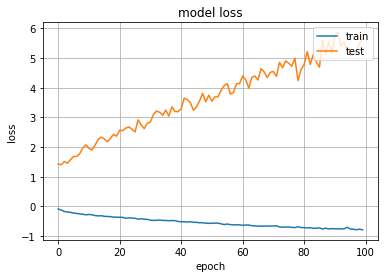

In [26]:
# train_data = x_train, y_train[:,0:2] 
# val_data = x_val, y_val[:,0:2] 
# print(y_val[:,0:2].shape)
# print(y_train[:,0:2].shape)
# ytr_cav_bit = deg2bit(ytr_cav)
# yval_cav_bit = deg2bit(yval_cav)
# yte_cav_bit = deg2bit(yte_cav)
# train_data = xtr_cav, ytr_cav_bit
# val_data = xval_cav, yval_cav_bit



ckpt_path = '/content/drive/My Drive/data/logs/aeroplane.h5'
# history = LossHistory()
hist = model.fit(train_data, val_data,n_epochs=100, batch_size=100)
# print(history.losses)
# saving weights at a checkpoint now only works for infinite mixture and not for single density model
# model.save_weights(ckpt_path)
model.evaluate(xte, yte_bit[:,0:2],data_part=1,return_per_image=False)

In [0]:

print(hist.history)
plt.plot(hist.history['loss'])

In [0]:
# ckpt_path = '/content/drive/My Drive/data/logs/airplaneweight.h5'
# model.load_weights(ckpt_path)

model.evaluate(x_test, y_test[:,0:2],data_part=1,return_per_image=False)
# print(y_val[:,0:2].shape)

MAAD error (1) : 97.758509 pm 2.775397SEM
log-likelihood (1) : -2.180008 pm 0.038917SEM


{'log_likelihood_mean': -2.1800084554018393,
 'log_likelihood_sem': 0.038916898237095036,
 'maad_loss': 97.75850896661932,
 'maad_loss_sem': 2.7753969675607655,
 'mean_kappa': 1.0,
 'std_kappa': 0.0}

[-0.6814233   0.73188955]


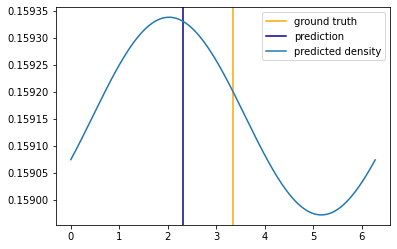

In [0]:
model.plot_pdf(xte[1:10],yte[1:10],fid=5)
# x = (np.array([0.9184249, 0.3955952]))
# x = np.expand_dims(x, axis=0)
# print(x[1])
# angles.bit2rad(x)

In [0]:
# print(x_vals_tiled)
xval = np.arange(0,2*np.pi,0.001)
yte_rad = np.deg2rad(yte)
a = model.pdf(xte[0:3],xval)
a.shape

Streaming output truncated to the last 5000 lines.
 [ 0.31609539 -0.94872741]
 [ 0.31609539 -0.94872741]]
(3, 2)
x_bit =  [[ 0.31704396 -0.94841084]
 [ 0.31704396 -0.94841084]
 [ 0.31704396 -0.94841084]]
(3, 2)
x_bit =  [[ 0.31799221 -0.94809333]
 [ 0.31799221 -0.94809333]
 [ 0.31799221 -0.94809333]]
(3, 2)
x_bit =  [[ 0.31894014 -0.94777486]
 [ 0.31894014 -0.94777486]
 [ 0.31894014 -0.94777486]]
(3, 2)
x_bit =  [[ 0.31988776 -0.94745545]
 [ 0.31988776 -0.94745545]
 [ 0.31988776 -0.94745545]]
(3, 2)
x_bit =  [[ 0.32083505 -0.94713508]
 [ 0.32083505 -0.94713508]
 [ 0.32083505 -0.94713508]]
(3, 2)
x_bit =  [[ 0.32178203 -0.94681378]
 [ 0.32178203 -0.94681378]
 [ 0.32178203 -0.94681378]]
(3, 2)
x_bit =  [[ 0.32272868 -0.94649152]
 [ 0.32272868 -0.94649152]
 [ 0.32272868 -0.94649152]]
(3, 2)
x_bit =  [[ 0.32367501 -0.94616832]
 [ 0.32367501 -0.94616832]
 [ 0.32367501 -0.94616832]]
(3, 2)
x_bit =  [[ 0.32462102 -0.94584417]
 [ 0.32462102 -0.94584417]
 [ 0.32462102 -0.94584417]]
(3, 2)
x_bit

(3, 6284)

In [0]:
print(a)

[[1.00811638e-13 1.02324310e-13 1.03860883e-13 ... 9.75873030e-14
  9.90490810e-14 1.00533923e-13]
 [9.29391317e-09 8.99801050e-09 8.71137834e-09 ... 9.97425828e-09
  9.65706032e-09 9.34978756e-09]
 [7.04777448e-12 6.76140215e-12 6.48654358e-12 ... 7.71599973e-12
  7.40278172e-12 7.10214360e-12]]


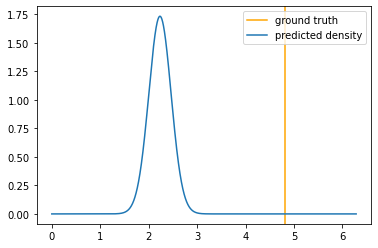

In [0]:
import numpy as np
from utils import angles
import matplotlib.pyplot as plt
%matplotlib inline
# angle = model.predict(xte)
fid = 0
plt.axvline(np.deg2rad(yte)[fid], c='orange', label='ground truth')
# plt.axvline(bit2rad(angle[fid]), c='darkblue', label='prediction')
plt.plot(xval, a[fid], label='predicted density')
plt.legend()

IndexError: ignored

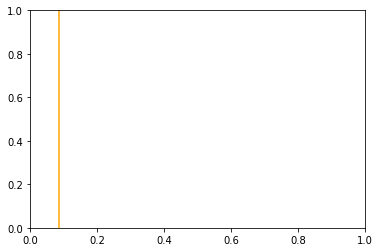

In [0]:
model.plot_pdf(xte,yte)

In [0]:
import math

# Conversion of von_mises_log_likelihood_tf
def von_mises_log_likelihood_py(y_true, mu_pred, kappa_pred, input_type='biternion'):
    '''
    Compute log-likelihood given data samples and predicted Von-Mises model parameters
    :param y_true: true values of an angle in biternion (cos, sin) representation
    :param mu_pred: predicted mean values of an angle in biternion (cos, sin) representation
    :param kappa_pred: predicted kappa (inverse variance) values of an angle in biternion (cos, sin) representation
    :param radian_input:
    :return:
    log_likelihood
    '''
    if input_type == 'degree':
        scaler = 0.0174533
        cosin_dist = torch.cos(scaler * (y_true - mu_pred)).to(device)
    elif input_type == 'radian':
        cosin_dist = torch.cos(y_true - mu_pred).to(device)
    elif input_type == 'biternion':
        cosin_dist = torch.reshape(torch.sum(torch.mul(y_true, mu_pred)), (-1,)).to(device)
    # log_likelihood = tf.exp(log_kappa) * cosin_dist - \
    #                  tf.log(2 * np.pi) + tf.log(bessel_approx_tf(tf.exp(log_kappa)))
    log_likelihood = kappa_pred.to(device) * cosin_dist - \
                     torch.log(2 * torch.tensor([math.pi]).to(device)) - log_bessel_approx_py(kappa_pred.to(device))
    return torch.reshape(log_likelihood, [-1, 1])
    # return tf.reduce_mean(log_likelihood)

# Conversion of log_bess_approx_tf


def log_bessel_approx_py(x):
    x = torch.reshape(x, [-1, 1])

    def _log_bessel_approx_0(x):
        bessel_taylor_coefs = torch.tensor([1.00000000e+00, 2.50000000e-01, 1.56250000e-02,
                                          4.34027778e-04, 6.78168403e-06])
        # bessel_taylor_coefs = tf.convert_to_tensor(bessel_taylor_coefs_np, np.float32)
        m = bessel_taylor_coefs.shape[0]
        deg = torch.reshape(torch.arange(0, m, 1)*2, [1, -1])
        n_rows = x.size(0)
        x_tiled = x.repeat(1,m)
        deg_tiled = deg.repeat(n_rows,1)
        deg_reshape = torch.reshape(bessel_taylor_coefs[0:m],[1,m])
        coef_tiled = deg_reshape.repeat(n_rows,1)
        deg_tiled = deg_tiled.type(torch.FloatTensor)
        val = torch.log(torch.sum(torch.pow(x_tiled, deg_tiled)*coef_tiled, axis=1))
        print('log_bessel_approx_0')
        return torch.reshape(val, [-1, 1])

    def _log_bessel_approx_large(x):
        print('log_bessel_approx_large')
        return x - 0.5*torch.log(2*torch.tensor([math.pi])*x)

    res = torch.where(x > 5.0, _log_bessel_approx_large(x), _log_bessel_approx_0(x))

    return res

In [0]:
import torch
y_pred = torch.ones(1,2)
mu_pred = torch.ones(1,2)
kappa_pred = torch.ones(1,1)


In [0]:
a = von_mises_log_likelihood_py(y_pred, mu_pred, kappa_pred, input_type='biternion')

In [0]:
def von_mises_neg_log_likelihood_keras(y_true, y_pred):
    '''

    :param y_true : array with ground truth angle in biternion representation (cos, sin) of shape [n_samples, 1]
    :param y_pred : array with predicted mean angle (cos, sin) and kappa of shape [n_samples, 3]
    :return: mean negative log likelihood
    '''
    mu_pred = y_pred[:, 0:2]
    kappa_pred = y_pred[:, 2:]
    return -K.mean(von_mises_log_likelihood_tf(y_true, mu_pred, kappa_pred, input_type='biternion'))

In [0]:
-torch.mean(a)

In [0]:
print(a)

In [0]:
b = von_mises_neg_log_likelihood_keras(y_true= tf.ones([1,2]),y_pred = tf.ones([1,2]))

In [0]:
print(b)

In [0]:
def von_mises_neg_log_likelihood_pytorch(y_true, y_pred):
    '''

    :param y_true : array with ground truth angle in biternion representation (cos, sin) of shape [n_samples, 1]
    :param y_pred : array with predicted mean angle (cos, sin) and kappa of shape [n_samples, 3]
    :return: mean negative log likelihood
    '''
    mu_pred = y_pred[:, 0:2]
    kappa_pred = y_pred[:, 2:]
    return -torch.mean(von_mises_log_likelihood_py(y_true, mu_pred, kappa_pred, input_type='biternion'))

In [0]:
y_pred = tf.ones([1,2])
mu_pred = y_pred[:, 0:2]
print(mu_pred)

In [0]:
import torch
c = von_mises_neg_log_likelihood_pytorch(y_true = torch.ones(1,2),y_pred= torch.ones(1,2))
print(c)

In [0]:
# Conversion of von_mises_log_likelihood_np function
def von_mises_log_likelihood_np_py(y, mu, kappa):
    """ Compute log-likelihood for multiple Von-Mises distributions

    Parameters
    ----------
    y: numpy array of shape [n_points, 2]
        utils in biternion (cos, sin) representation that will be used to compute likelihood
    mu: numpy array of shape [n_points, 2]
        mean values of Von-Mises distributions in biternion representation
    kappa: numpy array of shape [n_points, 1]
        kappa values (inverse variance) of multiple Von-Mises distributions

    Returns
    -------

    log_likelihood: numpy array of shape [n_points, 1]
        log-likelihood values for each sample
    """

    # if input_type == 'degree':
    #     scaler = 0.0174533
    #     cosin_dist = np.cos(scaler * (y - mu))
    # elif input_type == 'radian':
    #     cosin_dist = np.cos(y - mu)
    # elif input_type == 'biternion':

    cosin_dist = torch.reshape(torch.sum(torch.mul(y, mu), axis=1), [-1, 1])

    log_likelihood = kappa * cosin_dist - torch.log(2 * torch.tensor([math.pi])).to(device) - log_bessel_approx_py(kappa)

    return torch.reshape(log_likelihood,(-1, ))

In [0]:
# m = bessel_taylor_coefs.shape[0]
#         deg = torch.reshape(torch.arange(0, m, 1)*2, [1, -1])
#         n_rows = x.size(0)
#         x_tiled = x.repeat(1,m)
#         deg_tiled = deg.repeat(n_rows,1)
#         deg_reshape = torch.reshape(bessel_taylor_coefs[0:m],[1,m])
#         coef_tiled = deg_reshape.repeat(n_rows,1)
#         deg_tiled = deg_tiled.type(torch.FloatTensor)
#         val = torch.log(torch.sum(torch.pow(x_tiled, deg_tiled)*coef_tiled, axis=1))

def log_bessel_approx_np(x):

    x = torch.tensor(x).reshape(-1,1)

    def _log_bessel_approx_0(x):
        x = torch.reshape(-1,1)
        bessel_taylor_coefs = torch.tensor([1.00000000e+00, 2.50000000e-01, 1.56250000e-02,
                                          4.34027778e-04, 6.78168403e-06])
        m = bessel_taylor_coefs.shape[0]
        deg = torch.reshape(torch.arange(0, m, 1)*2, [1, -1])
        n_rows = x.size(0)
        x_tiled = x.repeat(1, m)
        deg_tiled = deg.repeat(n_rows,1)
        deg_reshape = torch.reshape.repeat(n_rows,1)
        coef_tiled = np.tile(bessel_taylor_coefs[0:m].reshape(1, m), [n_rows, 1])
        val = np.log(np.sum(np.power(x_tiled, deg_tiled)*coef_tiled, axis=1))
        return np.squeeze(val)

    def _log_bessel_approx_large(x):
        x = x.reshape([-1,1])
        val = x - 0.5*np.log(2*np.pi*x)
        return np.squeeze(val)
    
    res = np.zeros(x.shape)
    res[np.where(x > 5.0)] = _log_bessel_approx_large(x[x > 5.0])
    res[np.where(x <= 5.0)] = _log_bessel_approx_0(x[x <= 5.0])

    return res

In [0]:
def finetune_kappa(x,y_bit,max_kappa = 1000.0, verbose =False):
  ytr_preds_bit = model(x)[:,0:2]
  kappa_vals = torch.arange(0,max_kappa,1.0).to(device)
  log_likelihoods = torch.zeros(kappa_vals.shape).to(device)
  for i,kappa_val in enumerate(kappa_vals):
    kappa_preds = torch.ones([x.shape[0], 1]).to(device) * kappa_val
    log_likelihoods[i] = torch.mean(von_mises_log_likelihood_np_py(y_bit, ytr_preds_bit,kappa_preds))
    if verbose:
      print("kappa: %f, log-likelihood: %f" % (kappa_val,log_likelihoods[i]))
  max_ix = torch.argmax(log_likelihoods)
  fixed_kappa_value = kappa_vals[max_ix]
  if verbose:
    print("best kappa : %f" % fixed_kappa_value)
  return fixed_kappa_value


In [0]:
def pdf(x, x_vals):
  n_images = x.shape[0]

  x_vals_tiled = torch.ones(n_images).to(device)
  
  preds = model(x)

  mu_preds_bit = preds[:, 0:2]

  if predict_kappa:
    kappa_preds = preds[:,2:]
  else:
    kappa_preds = torch.ones([x.shape[0], 1]).to(device) * fixed_kappa_value

  log_likelihoods = torch.zeros([n_images, len(x_vals)])

  for xid, xval in enumerate(x_vals):

    x_bit = x(x_vals_tiled * xval)

    log_likelihoods[:,xid] = torch.exp(torch.squeeze(von_mises_log_likelihood_np(x_bit, mu_preds_bit, kappa_preds)))
  return log_likelihoods


In [0]:
import math

def rad2bit_py(angles_rad):
  """ radians to biternion ([cos, sin])
  """
  return torch.tensor([torch.cos(angles_rad), torch.sin(angles_rad)]).to(device).T

def deg2bit_py(angles_deg):
  """ degrees to biternion ([cos, sin])
  """
  angles_rad = angles_deg * torch.tensor([math.pi]).to(device) / 180
  return torch.tensor([torch.cos(angles_rad),torch.sin(angles_rad)]).to(device).T

def deg2rad(angle_deg):
  return angle_deg * torch.tensor([math.pi]).to(device) / 180

def rad2deg(angle_rad):

  return angle_rad * 180 / torch.tensor([math.pi]).to(device)

def bit2deg_py(angles_bit):
  """ biternion ([cos, sin]) ->  degrees
  """
  return (rad2deg(torch.atan2(angles_bit[:,1], angles_bit[:,0])) + 360) %360




In [0]:
import torch
device = 'cpu'
angles_rad = torch.ones(1,1)
angles_deg = torch.ones(1,1)
angles_bit = torch.ones(1,2)
# torch.cos(angles_rad)
print(rad2bit_py(angles_rad))

print(deg2bit_py(angles_deg))

print(bit2deg_py(angles_bit))


tensor([0.5403, 0.8415])
tensor([0.9998, 0.0175])
tensor([45.])


In [0]:
def maad_from_deg_py(y_pred, y_target):
    return rad2deg(torch.abs(torch.atan2(torch.sin(deg2rad(y_target - y_pred)).to(device), torch.cos(deg2rad(y_target - y_pred)).to(device)).to(device)).to(device))


In [0]:
import torch
device = 'cpu'
y_pred = torch.ones(1,1).to(device)
y_target = torch.ones(1,1).to(device)
y_true = torch.ones(1,1).to(device)
fixed_kappa_value = 1
# maad_from_deg_py(y_pred, y_target)

In [0]:
def _von_mises_neg_log_likelihood_keras_fixed_py(y_true, y_pred):
  mu_pred = y_pred[:, 0:2]
  kappa_pred = torch.ones([y_pred.shape[0], 1]).to(device) * fixed_kappa_value
  print('von mises keras fixed')
  return -torch.mean(von_mises_log_likelihood_py(y_true, mu_pred, kappa_pred))

In [0]:
_von_mises_neg_log_likelihood_keras_fixed_py(y_true,y_pred)

von mises keras fixed
log_bessel_approx_large
log_bessel_approx_0


tensor(1.0738)

In [0]:
y_true = tf.keras.backend.random_uniform([10,2])
y_pred = tf.keras.backend.random_uniform([10,2])

In [0]:
def _von_mises_neg_log_likelihood_keras_fixed(y_true, y_pred):
                    mu_pred = y_pred[:, 0:2]
                    kappa_pred = tf.ones([tf.shape(y_pred[:, 2:])[0], 1])*fixed_kappa_value
                    print('von mises keras fixed')
                    return -K.mean(von_mises_log_likelihood_tf(y_true, mu_pred, kappa_pred))

fixed_kappa_value = 1
_von_mises_neg_log_likelihood_keras_fixed(y_true, y_pred)

von mises keras fixed
log_bessel_approx_large
log_bessel_approx_0


<tf.Tensor: shape=(), dtype=float32, numpy=1.4038321>

In [0]:
y_pred[:,2:]

<tf.Tensor: shape=(10, 0), dtype=float32, numpy=array([], shape=(10, 0), dtype=float32)>

In [0]:
a = torch.randn((1, 3),dtype=float)
print(a)
torch.std(a,dim=1,unbiased=False)


tensor([[ 0.1475, -1.2514, -0.0056]], dtype=torch.float64)


tensor([0.6265], dtype=torch.float64)

In [0]:
import numpy as np
b = a.numpy()
print(b)
np.std(b)

[[ 0.1474928  -1.25144377 -0.00555085]]


0.6265155035817832